# Isomorphic Augmentation Experiment

In this notebook we want to test the hypothesis that most of the performance gains in the SimCLR framework come from the inductive bias of the Convolutional Neural Networks.

We will train the Resnet50 image encoder on the CIFAR10 dataset in the following setups:

1. Use the SimCLR framework with InfoNCE (NT-Xent) without the projection head and no changes to the data $f(x)$
2. Use the SimCLR framewok without the projection head and do an arbitrary permutation to the pixel's positions in the image before training. So our encoder during training will become $f(Permute(x))$
3. Use the SimCLR framewok without the projection head and do a discrete cosine transform for the image before training $f(DCOS(x))$

The goal is to compare the performance of these transformations based on:

- InfoNCE loss (The encoders are trained on 400 epochs with a batch of 120)
- Linear probing (Each in the respective domain (after information-preserving mapping)) - linear probes are trained for 50 epochs with a batch of 120
- K-means scoring

### Loading the encoder

The following cell loads the encoder trained for 400 epochs using InfoNCE loss, CIFAR10 dataset and SimCLR framework. You can also see the training losses per batch and per epoch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


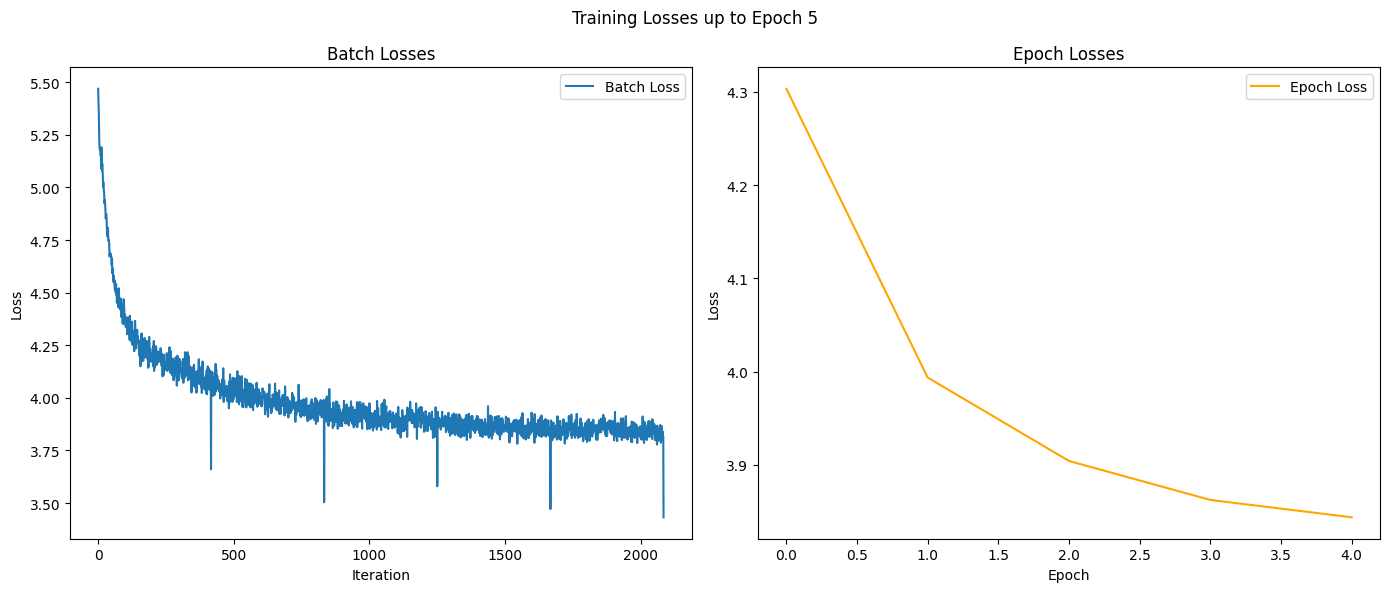

In [90]:
%load_ext autoreload
%autoreload 2

from torch import nn
import torch
from tqdm import tqdm
import torchvision.models as models

# Load the checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the ResNet-50 encoder (remove the final fc layer for feature extraction)
encoder = models.resnet50(weights=None)
encoder.fc = nn.Identity()  # remove classification head
checkpoint_path = './checkpoints_isomorphic_training_id_cifar10/encoder_epoch_5.pt'
checkpoint = torch.load(checkpoint_path, map_location=device)

encoder.load_state_dict(checkpoint['encoder_state'])
encoder = encoder.to(device)
encoder.eval()

# Retrieve the training losses from the checkpoint
batch_losses = checkpoint.get('losses', [])
epoch_losses = checkpoint.get('epoch_losses', [])
final_epoch = checkpoint.get('epoch', 'Unknown')

# Plot the losses
plt.figure(figsize=(14, 6))

# Plot batch losses
plt.subplot(1, 2, 1)
plt.plot(batch_losses, label='Batch Loss')
plt.title('Batch Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

# Plot epoch losses
plt.subplot(1, 2, 2)
plt.plot(epoch_losses, label='Epoch Loss', color='orange')
plt.title('Epoch Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle(f"Training Losses up to Epoch {final_epoch}")
plt.tight_layout()
plt.show()

## Loading the dataset

Here we load the CIFAR10 dataset to examine the data samples

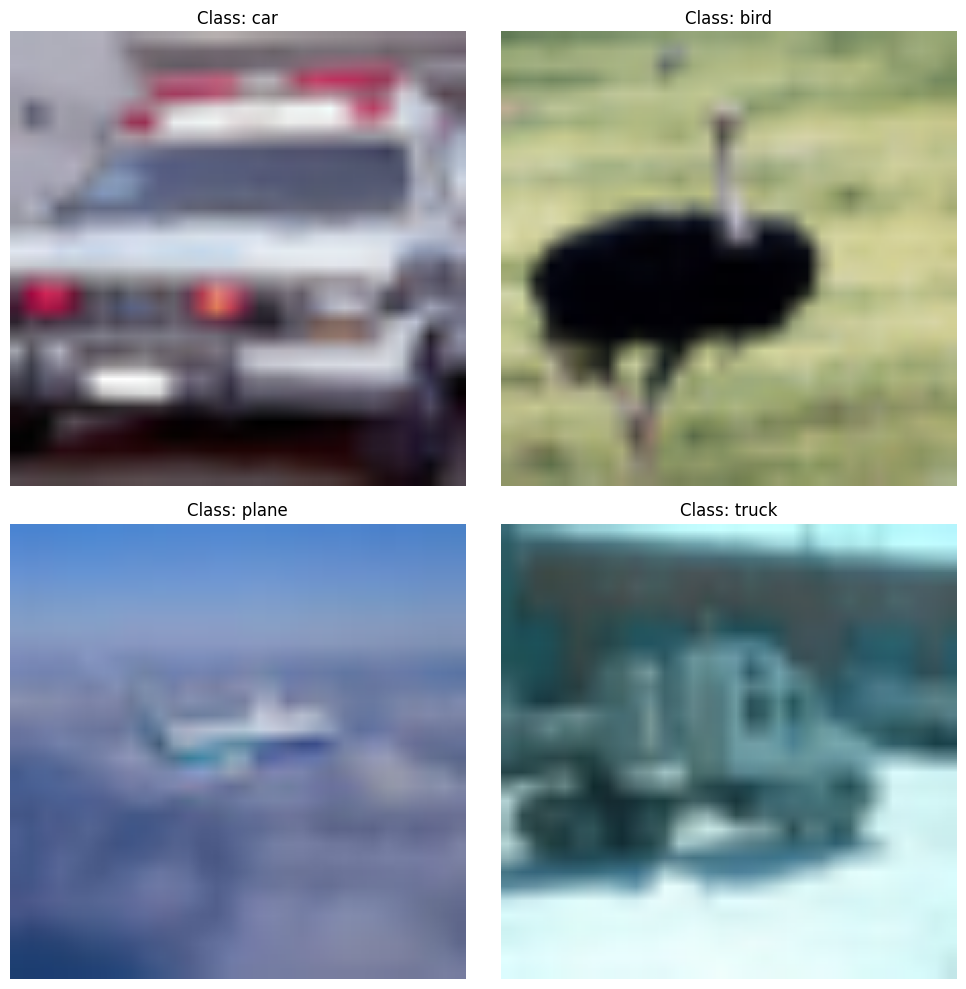

In [91]:
from torchvision import transforms
from data.cifar10 import load_cifar_10

import matplotlib.pyplot as plt
import numpy as np


batch_size = 100

# Transformation: resize + convert to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 expects 224x224 images
    transforms.ToTensor()
])

train_loader = load_cifar_10(transforms=transform, batch_size=batch_size)['train']

# Function to convert tensor to numpy image
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))  # C x H x W -> H x W x C
    return img

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def visualize_images(plt, images):
    # Create a figure to display images
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(4):
        img = imshow(images[i])
        axes[i].imshow(img)
        axes[i].set_title(f'Class: {classes[labels[i]]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_images(plt, images)

In [94]:
from evals.linear_probing import LinearProbeEvaluator

data = load_cifar_10(transforms=transform, batch_size=batch_size, split_validation=True, add_test=True)

train_data_loader = data['train']
val_data_loader = data['val']
test_data_loader = data['test']

# encoder, embedding_dim, num_classes
probe = LinearProbeEvaluator(encoder, 2048, 10, device=device)
# probe.train(train_data_loader, val_data_loader, epochs=30)

# probe.evaluate(test_data_loader)

## Invertible permutations

Now, we will give a few examples of invertible permutations applied to images and reversed back

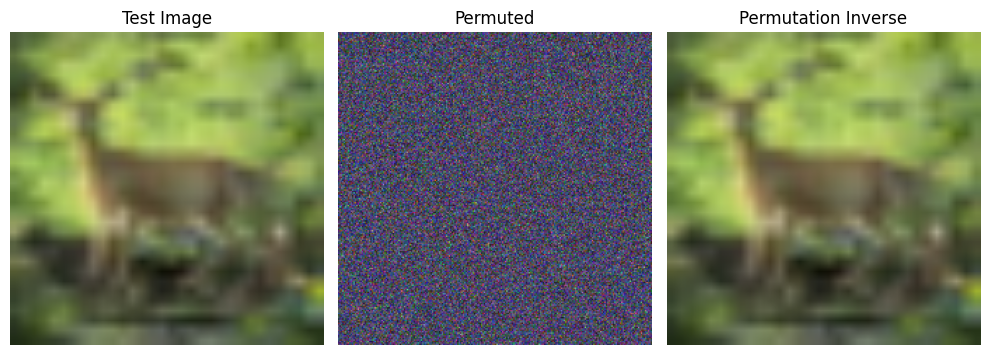

In [115]:
from transformations.image_permutations import ImagePermutationTransform

data = load_cifar_10(transforms=transform, batch_size=1)['train']

images, labels = next(iter(data))
test_image = images[0]

perm_transform = ImagePermutationTransform(test_image.shape[-2], test_image.shape[-1])
img_permuted = perm_transform(test_image.unsqueeze(0))
un_permuted_img = perm_transform.inverse(img_permuted)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))

axes[0].imshow(imshow(test_image))
axes[0].set_title(f'Test Image')
axes[0].axis('off')

axes[1].imshow(imshow(img_perm.squeeze(0)))
axes[1].set_title(f'Permuted')
axes[1].axis('off')

axes[2].imshow(imshow(un_permuted_img.squeeze(0)))
axes[2].set_title(f'Permutation Inverse')
axes[2].axis('off')

plt.tight_layout()
plt.show()